In [1]:
# Preamble

from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [2]:
import sys
sys.path.append('../../../astro_codes/')
#------------------------------------
from SFR_conversions import L12_to_sfr, L22_to_sfr, FUV_to_sfr, Mag_to_lum

## Load the required data

In [3]:
gz_data = Table.read('../matched_fits/gz_data.fits')
chang_in_matched = Table.read('../matched_fits/chang_in_matched.fits')
chang_out_matched = Table.read('../matched_fits/chang_out_matched.fits')
nsa_matched = Table.read('../matched_fits/nsa_matched.fits')
samples = Table.read('../matched_fits/samples.fits')
masks = Table.read('../matched_fits/bad_flux_mask.fits')
print('Loaded all data.')

Loaded all data.


In [4]:
fuv_mags = nsa_matched['M_corrected'][:,0]
fuv_flux = nsa_matched['PETROFLUX'][:,0]
fuv_flux_error = (nsa_matched['PETROFLUX_IVAR'][:,0])**(-1/2)
fuv_snr = fuv_flux/fuv_flux_error

w3_lums = chang_out_matched['lrest_w3']
w3_flux = chang_in_matched['flux_w3']
w3_flux_error = chang_in_matched['flux_w3_e']
w3_snr = w3_flux/w3_flux_error

w4_lums = chang_out_matched['lrest_w4']
w4_flux = chang_in_matched['flux_w4']
w4_flux_error = chang_in_matched['flux_w4_e']
w4_snr = w4_flux/w4_flux_error

has_w4 = masks['w4']
has_w3 = (masks['w3']) & (masks['w4'] == False)
has_fuv = (masks['fuv'])

sfr_fuv, sfr_fuv_error = FUV_to_sfr(fuv_mags,snr=fuv_snr)
sfr_w3, sfr_w3_error = L12_to_sfr(w3_lums,snr=w3_snr)
sfr_w4, sfr_w4_error = L22_to_sfr(w4_lums,snr=w4_snr)

sfr_fuv[has_fuv == False] = -999
sfr_fuv_error[has_fuv == False] = -999

sfr_ir = sfr_w4.copy()
sfr_ir[has_w3] = sfr_w3[has_w3]
sfr_ir[(has_w3 == False) & (has_w4 == False)] = -999

sfr_ir_error = sfr_w4_error.copy()
sfr_ir_error[has_w3] = sfr_w3_error[has_w3]
sfr_ir_error[(has_w3 == False) & (has_w4 == False)] = -999

sfr_table = Table()
sfr_table['fuv'] = sfr_fuv
sfr_table['fuv_error'] = sfr_fuv_error
sfr_table['nir'] = sfr_ir
sfr_table['nir_error'] = sfr_ir_error

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
../../../astro_codes/SFR_conversions.py:76: RuntimeWarning: overflow encountered in power
  S = 3631*10**(Mag/-2.5)*u.Jy # AB -> flux density
/home/ppxrh/anaconda3/lib/python3.4/site-packages/astropy/table/column.py:268: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self.data.__eq__(other)
../../../astro_codes/SFR_conversions.py:100: RuntimeWarning: divide by zero encountered in true_divide
  sigma_sfr = np.log10(np.log(10)*(L.value/snr)*(1.08e-28)) + 0.26
../../../astro_codes/SFR_conversion

In [5]:
#_ = make_figure('$\mathrm{SSFR_{NIR}} \, (\log{\mathrm{yr^{-1}}})$','$\mathrm{SSFR_{FUV}} \, (\log{\mathrm{yr^{-1}}})$')

In [6]:
in_ml = samples['in_mass_limit']
in_spiral = (samples['in_mass_limit']) & (samples['in_spiral']) & (samples['axial_ok'])

In [20]:
import matplotlib.gridspec as gridspec
from contours import kde_contour

def make_figure(xlabel='x', ylabel='y'):
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(3,3)
    ax0 = plt.subplot(gs[0,0:2])
    ax1 = plt.subplot(gs[1:,2])
    ax2 = plt.subplot(gs[1:,0:2])
    axarr = [ax0, ax1, ax2]
    plt.subplots_adjust(hspace=0,wspace=0)
    axarr[2].set_xlabel(xlabel)
    axarr[2].set_ylabel(ylabel)
    return fig, axarr


def histogram(data,bins,fill_properties,line_properties,
              fill=False,weights=None,normed=True,orientation='horizontal'):
    
    if fill == True:
        _ = plt.hist(data,bins,normed=normed,histtype='stepfilled',
                     weights=weights,orientation=orientation,
                     color=fill_properties['color'],
                     alpha=fill_properties['alpha'])
    
    _ = plt.hist(data,bins,normed=normed,histtype='step',
                 weights=weights,orientation=orientation,
                 color=line_properties['color'],
                 linewidth=line_properties['linewidth'],
                 linestyle=line_properties['linestyle'],
                 alpha=line_properties['alpha'])
    return None


def compare_xy_data(x,y,xy_range,N_bins,weights=None,xlabel='x',ylabel='y',
                    fill=False,contour_fill_properties=None,
                    hist_fill_properties=None,line_properties=None,
                    bandwidth=None,levels=[0.2,0.4,0.6,0.8]):
    
    xmin, xmax, ymin, ymax = xy_range
    
    if xy_range == None:
        x_hist = x
        y_hist = y
        x_contour = x
        y_contour = y
        w_x, w_y, w_c = [weights, weights, weights]
    else:
        x_ok = (x >= xmin) & (x <= xmax)
        y_ok = (y >= ymin) & (y <= ymax)
        x_hist = x[x_ok]
        y_hist = y[y_ok]
        x_contour = x[(x_ok) & (y_ok)]
        y_contour = y[(x_ok) & (y_ok)]
        if weights != None:
            w_x = weights[x_ok]
            w_y = weights[y_ok]
            w_c = weights[(x_ok) & (y_ok)]
        else:
            w_x, w_y, w_c = [None,None,None]
    c_fp = {'colormap':'Greys',
           'alpha':0.5}  

    h_fp = {'color':'k',
            'alpha':0.5}
    
    lp = {'color':'k',
          'alpha':1,
          'linewidth':1,
          'linestyle':'solid'}
    
    if line_properties != None:
        for l in line_properties.keys():
            lp[l] = line_properties[l]
    if hist_fill_properties != None:
        for f in hist_fill_properties.keys():
            h_fp[f] = hist_fill_properties[f]
    if contour_fill_properties != None:
        for f in hist_fill_properties.keys():
            c_fp[f] = hist_fill_properties[f]
    
    x_bins = np.linspace(xy_range[0],xy_range[1],N_bins[0]+1)
    y_bins = np.linspace(xy_range[2],xy_range[3],N_bins[1]+1)
    
    fig, axarr = make_figure(xlabel,ylabel)
    
    plt.sca(axarr[0])
    _ = histogram(x_hist,x_bins,c_fp,lp,fill,weights=w_x,orientation='vertical')
    plt.sca(axarr[1])
    _ = histogram(y_hist,y_bins,c_fp,lp,fill,weights=w_y)
    plt.sca(axarr[2])
    #_ = plt.scatter(x_contour,y_contour,alpha=0.01)
    _ = kde_contour(x_contour,y_contour,xy_range,bandwidth,fill,c_fp,lp,levels,weights=w_c)
    bandwidth = _[-1]
    
    axarr[0].set_xlim(xmin,xmax)
    axarr[1].set_ylim(ymin,ymax)
    axarr[2].axis((xmin,xmax,ymin,ymax))
    
    return fig, axarr, bandwidth

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


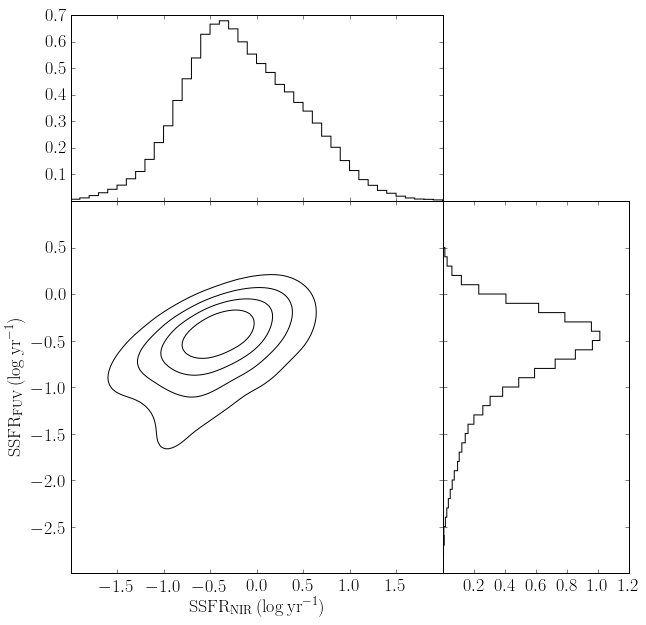

In [19]:
xy_range = (-2,2,-3,1)
N_bins = (40,40)

x = sfr_table['nir']
y = sfr_table['fuv']
w = masks['fuv_weights']

fig, axarr, _ = compare_xy_data(x,y,xy_range,N_bins,
                                xlabel='$\mathrm{SSFR_{NIR}} \, (\log{\mathrm{yr^{-1}}})$',
                                ylabel='$\mathrm{SSFR_{FUV}} \, (\log{\mathrm{yr^{-1}}})$')